In [1]:
from datetime import datetime
import pandas as pd
import numpy as np
import plotly.express as px
import warnings
import plotly.io as pio
pio.renderers.default = "svg"

layout = {
    'showlegend': True,
    'margin': {'b':10, 'l':20, 'r':50, 't':50},
    'font': {'size': 19},
    'xaxis': {'zerolinewidth': 2, 'zerolinecolor':'black'},
    'yaxis': {'zerolinewidth': 2, 'zerolinecolor':'black'},
    'template': 'plotly_white',
}

px.defaults.color_discrete_sequence = px.colors.qualitative.T10

# Import Quoilin dataset
Data available at: https://github.com/squoilin/Self-Consumption/releases Synthetic.Household.Profiles.h5

In [2]:
%%script false --no-raise-error
filename = "../../../pylec/studies/data/Synthetic.Household.Profiles.h5"
with warnings.catch_warnings():
    warnings.filterwarnings("ignore")
    df = pd.read_hdf(filename, "TimeSeries")

with warnings.catch_warnings():
    warnings.filterwarnings("ignore")
    houseinfo = pd.read_hdf(filename, "HouseInfo")
mask = (houseinfo.Country == "France") & (houseinfo.Nmonths == "12")
df = df.loc[:, [str(a) for a in houseinfo[mask].pdIndex.tolist()]]

df["Index"] = pd.date_range(
    start="01-01-2019 00:00:00", end="31-12-2019 23:45:00", freq="15T"
)
df.set_index("Index", drop=True, inplace=True)

# --------------------------------------------
dateparse = lambda x: datetime.strptime(x, '%Y%m%d:%H%M')
pv = pd.read_csv("Timeseries_44.931_4.896_SA_1kWp_crystSi_14_38deg_-3deg_2014_2015.csv",
                 parse_dates=[0], index_col=[0], header=8, skipfooter=13, engine='python',
                 date_parser=dateparse)
# P is in W for a 1kW PV so we just have to change it to kW to get the coef 
pv = pv[['P']] / 1000
pv.columns = ["pv_1kw"]
pv = pv.loc['2014-01-01 00:00:00':'2015-01-01 00:10:00', :]

# Shifting things by 11 min, but whatever.
pv['Index'] = pd.date_range(start='2019-01-01 00:00:00',
                            end='2020-01-01 00:00:00', freq='60T')
pv.set_index('Index', drop=True, inplace=True)

# Interpolating to get 15-min interval values
pv = pv.resample('15T').interpolate('time')
pv.drop(pv.tail(1).index, inplace=True)

# --------------------------------------------
df["pv_1kw"] = pv["pv_1kw"]
df.to_pickle("fr_quoilin_data_valence.pickle")

In [3]:
df = pd.read_pickle("fr_quoilin_data_valence.pickle")
df.head()

,2000900,2000901,2000903,2000904,2000905,2000906,2000907,2000908,2000909,2000910,...,2001188,2001189,2001190,2001192,2001193,2001194,2001195,2001197,2001199,pv_1kw
Index,,,,,,,,,,,,,,,,,,,,,
2019-01-01 00:00:00,0.295204,0.327625,0.483190,0.687899,0.143035,0.221557,0.224354,0.348925,2.359406,0.116382,...,0.079687,0.757643,0.080509,0.546715,0.026350,0.145583,0.160894,0.079701,1.420406,0.0
2019-01-01 00:15:00,0.223572,0.519240,0.236277,0.976978,0.178788,0.245871,0.485754,0.131845,1.064770,0.102974,...,0.269552,1.211409,0.074367,0.528931,0.057051,0.128810,0.155660,0.113194,0.641011,0.0
2019-01-01 00:30:00,0.237445,0.397812,0.151005,0.742844,0.232710,0.277901,0.594242,0.080997,0.897831,0.068910,...,0.107144,1.195561,0.083457,0.640498,0.069793,0.086199,0.188493,0.086067,0.540511,0.0
2019-01-01 00:45:00,0.477201,0.397999,0.398284,0.587097,0.285982,0.267720,0.512216,0.141001,1.433766,0.063750,...,0.165818,1.145802,0.107888,0.544124,0.060159,0.079745,0.160131,0.068022,0.863154,0.0
2019-01-01 01:00:00,0.415664,0.275134,0.108359,0.789470,0.181792,0.258787,0.185333,0.127379,1.140404,0.069257,...,0.250045,1.544101,0.036674,0.560161,0.031038,0.084432,0.178843,0.090153,0.814874,0.0


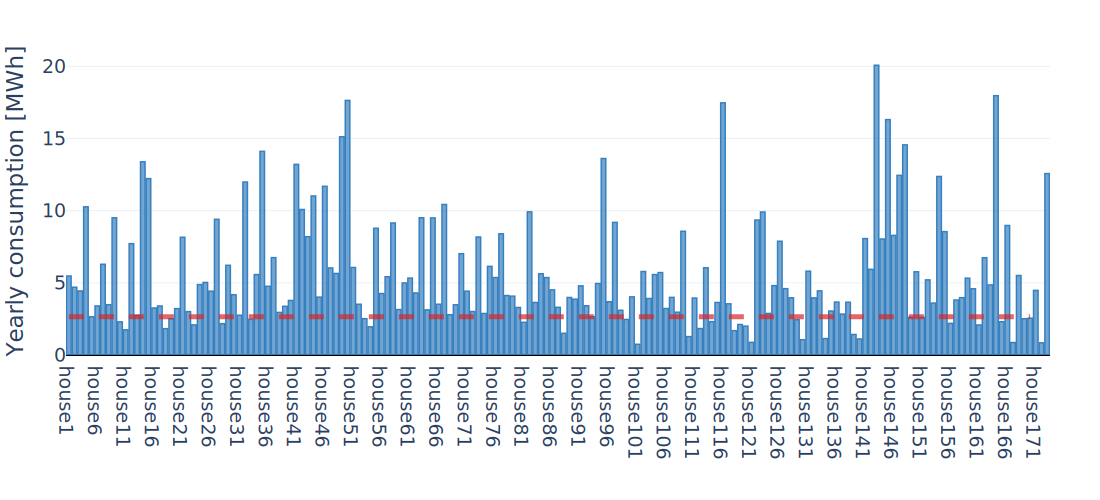

In [6]:
graph = df[[col for col in df.columns if "pv_1kw" not in col]].copy()
graph.columns = ["house" + str(n) for n in range(1, len(graph.columns) + 1)]
fig = px.bar(graph.sum() * 15 / 60 / 1000)
fig.data[0].update(
    {'marker': {'color': 'rgba(55, 128, 191, 0.7)',
                'line': {'width': 1.5,
                'color': 'rgba(55, 128, 191, 1.0)'}}})

# 'Reference for 100m2, 4 people, no elec. heating'
fig.add_shape(
  type='line',
  y0=2650/1000, y1=2650/1000, x0="house1", x1="house170",
  line={'dash': 'dash', 'width': 5,
        'color': 'rgba(214, 39, 40, 0.7)'})

fig.update_layout(
    layout,
    width=1100,
    showlegend=False,
    xaxis_title="",
    yaxis_title="Yearly consumption [MWh]")
fig.show()

# Set study on 20 households

In [7]:
nb_houses = 20

In [8]:
house_ids=[
    "2000989",
    "2001197",
    "2000914",
    "2001123",
    "2000964",
    "2001189",
    "2001111",
    "2001179",
    "2000909",
    "2000918",
    "2000994",
    "2001107",
    "2000913",
    "2001139",
    "2000960",
    "2001149",
    "2001165",
    "2000954",
    "2001114",
    "2000926",
]
df = df[house_ids + ["pv_1kw"]]
print(f"Average consumption is {round((df[house_ids].sum() * 15 / 60).mean() / 1000, 2)} MWh")
df.head()

Average consumption is 5.56 MWh


,2000989,2001197,2000914,2001123,2000964,2001189,2001111,2001179,2000909,2000918,...,2001107,2000913,2001139,2000960,2001149,2001165,2000954,2001114,2000926,pv_1kw
Index,,,,,,,,,,,,,,,,,,,,,
2019-01-01 00:00:00,0.420397,0.079701,0.857910,0.031886,0.181189,0.757643,0.190965,0.227143,2.359406,0.055817,...,0.070520,0.142502,0.255521,0.582962,0.180451,1.942729,3.863059,0.121460,0.469955,0.0
2019-01-01 00:15:00,0.545898,0.113194,1.250317,0.141971,0.137223,1.211409,0.093381,0.188724,1.064770,0.061609,...,0.088147,0.223753,0.345453,0.525038,0.200254,3.050416,5.486453,0.134062,0.684911,0.0
2019-01-01 00:30:00,0.434237,0.086067,1.391707,0.100812,0.145738,1.195561,0.059680,0.132277,0.897831,0.050262,...,0.114732,0.041090,0.326808,1.252299,0.226341,0.560178,4.171616,0.109371,0.762364,0.0
2019-01-01 00:45:00,0.282571,0.068022,1.058611,0.039150,0.292894,1.145802,0.157409,0.154381,1.433766,0.044647,...,0.140997,0.281691,0.546796,0.521619,0.218049,3.840278,3.296981,0.097153,0.579897,0.0
2019-01-01 01:00:00,0.269873,0.090153,0.930174,0.074543,0.215576,1.544101,0.051027,0.251023,1.140404,0.037189,...,0.085866,0.043304,0.188321,0.512975,0.145118,0.313930,4.377657,0.073465,0.317332,0.0


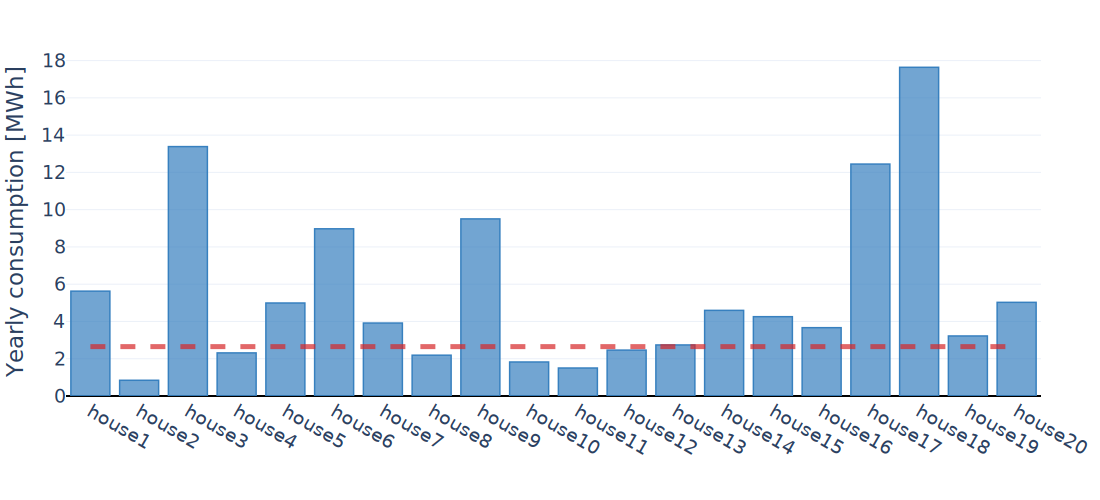

In [10]:
graph = df[[col for col in df.columns if "pv_1kw" not in col]].copy()
graph.columns = ["house" + str(n) for n in range(1, len(graph.columns) + 1)]
fig = px.bar(graph.sum() * 15 / 60 / 1000)
fig.data[0].update(
    {'marker': {'color': 'rgba(55, 128, 191, 0.7)',
                'line': {'width': 1.5,
                'color': 'rgba(55, 128, 191, 1.0)'}}})

# 'Reference for 100m2, 4 people, no elec. heating'
fig.add_shape(
  type='line',
  y0=2650/1000, y1=2650/1000, x0="house1", x1="house20",
  line={'dash': 'dash', 'width': 5,
        'color': 'rgba(214, 39, 40, 0.7)'})

fig.update_layout(
    layout,
    width=1100,
    showlegend=False,
    xaxis_title="",
    yaxis_title="Yearly consumption [MWh]")
fig.show()

In [8]:
df.describe().T[["mean", "min", "max"]]

,mean,min,max
2000989,0.642409,0.009760,15.452793
2001197,0.096313,0.002070,2.248960
2000914,1.527877,0.007914,73.415019
2001123,0.264018,0.010254,8.702582
2000964,0.569726,0.018387,17.223078
2001189,1.024281,0.014418,34.618334
2001111,0.446941,0.011408,9.133565
2001179,0.250011,0.008664,4.353821
2000909,1.084943,0.015853,23.098691
2000918,0.208345,0.004761,7.726401


In [11]:
df["community_kW"] = df[house_ids].sum(axis=1)
df.drop(house_ids, axis=1, inplace=True)

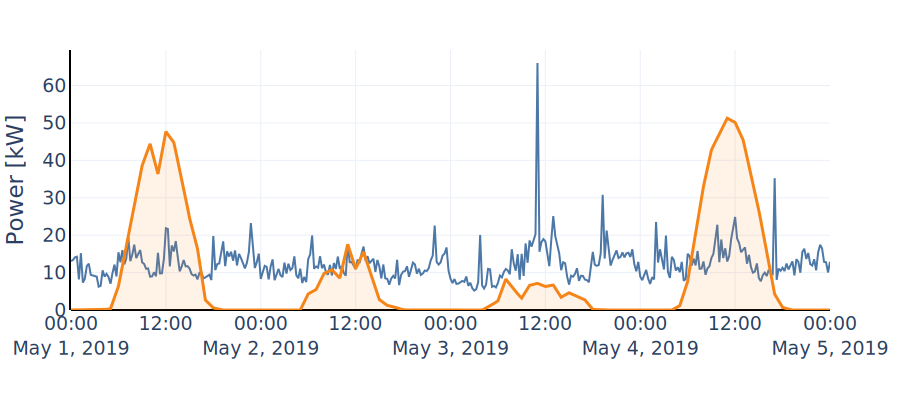

In [12]:
graph = df.loc["2019-05-01 00:00:00":"2019-05-05 00:00:00", :].copy()
graph.pv_1kw *= nb_houses * 3

fig = px.line(graph, y=["community_kW", "pv_1kw"])
fig.data[1].update(fill="tozeroy", line_width=3,
                   fillcolor="rgba(255, 127, 14, 0.1)")
fig.update_layout(
    layout,
    height=400,
    width=900,
    showlegend=False,
    xaxis_title="",
    yaxis_title="Power [kW]",
    yaxis_showline=True, yaxis_linewidth=2, yaxis_linecolor='black',
    xaxis_showline=False, xaxis_linewidth=2, xaxis_linecolor='black')
fig.show()

In [11]:
fig.write_image("results/sample_valence.svg")

# Define boundaries for storage experiment

In [13]:
# TEST
graph = df.copy()
df[["community_kW", "pv_1kw"]].groupby(pd.Grouper(freq="365D")).sum() * 15 / 60 / 1000

,community_kW,pv_1kw
Index,,
2019-01-01,111.1246,1.367925


In [14]:
def self_consumption_production(df, cons_col, prod_col, timing):
    """Return self-consumption and self-production in %"""
    result = {}
    local = df[[cons_col, prod_col]].groupby(pd.Grouper(freq=timing)).sum().min(axis=1).sum()  # unit do not matter
    result[f"self_cons"] = local * 100 / df[prod_col].sum()
    result[f"self_prod"] = local * 100 / df[cons_col].sum()
    return result

In [15]:
pv_sizes = list(np.linspace(0.1, 5, 100))
self_prod = {}
for timing in ["15T", "D", "365D"]:
    self_prod[timing] = []
    for pv_size in pv_sizes:
        graph = df.copy()
        graph.pv_1kw *= nb_houses * pv_size
        res = self_consumption_production(graph, cons_col="community_kW", prod_col="pv_1kw", timing=timing)
        self_prod[timing].append(res['self_prod'])

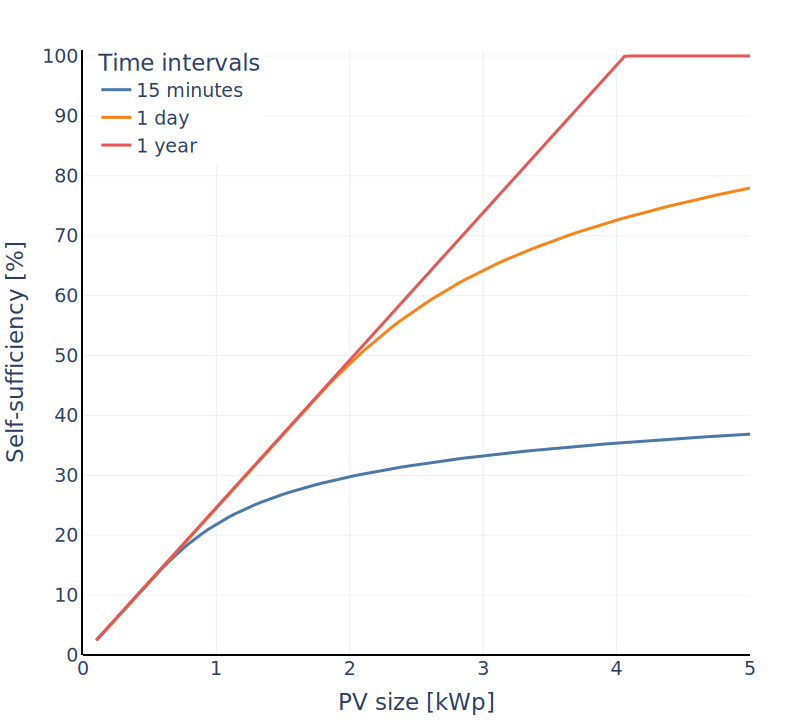

In [16]:
graph = pd.DataFrame(index=pv_sizes, data=self_prod)
graph.columns = ["15 minutes", "1 day", "1 year"]
_fig = px.line(graph)
_fig.update_traces(line_width=3)
_fig.update_layout(
    layout,
    height=720,
    width=800,
    yaxis_title="Self-sufficiency [%]",
    yaxis_dtick=10,
    xaxis_title="PV size [kWp]",
    yaxis_showline=True, yaxis_linewidth=2, yaxis_linecolor='black',
    xaxis_showline=False, xaxis_linewidth=2, xaxis_linecolor='black',
    yaxis_range=[0, 101],
    xaxis_range=[0, 5],
    showlegend=True,
    legend={"x": 0.02, "y": 1.015},
    legend_title="Time intervals")
_fig.show()

# Add physical storage and control

In [17]:
df.head()

,pv_1kw,community_kW
Index,,
2019-01-01 00:00:00,0.0,12.930472
2019-01-01 00:15:00,0.0,15.765637
2019-01-01 00:30:00,0.0,12.099126
2019-01-01 00:45:00,0.0,14.475988
2019-01-01 01:00:00,0.0,10.696315


In [18]:
def def1_self_production(df, cons_col, prod_col, storage):
    """
    Defintion 1: Merge storage in production.
    """
    result = {}
    _df = df.copy()
    _df["prod_before_storage"] = _df[prod_col]
    _df[prod_col] = _df[prod_col] - _df[storage]
    
    local = _df[[cons_col, prod_col]].min(axis=1).sum()  # unit do not matter 
    result[f"self_prod"] = local * 100 / _df[cons_col].sum()
    result[f"self_cons"] = local * 100 / _df["prod_before_storage"].sum()
    return result

In [19]:
def best_course_action(cons, prod):
    in_kw = prod - cons
    return in_kw

def battery_constraints(in_kw, soc_kwh, spec, deltat=15):
    # Energy
    offset = spec["max_kwh"] * spec["offset"]
    max_charg_kW = max(
        0, (spec["max_kwh"] - offset - soc_kwh) / (spec["eta"] * deltat / 60)
    )
    if in_kw > max_charg_kW:
        in_kw = max_charg_kW

    max_discharg_kW = min(0, (0 + offset - soc_kwh) * spec["eta"] / (deltat / 60))
    if in_kw < max_discharg_kW:
        in_kw = max_discharg_kW

    # Power
    if in_kw > spec["max_kw"]:
        in_kw = spec["max_kw"]

    if in_kw < -spec["min_kw"]:
        in_kw = -spec["min_kw"]
    return in_kw

def update_soc(in_kw, previous_soc_kwh, spec, deltat=15):
    # Power
    assert in_kw <= spec["max_kw"], f"{in_kw} <= {spec['max_kw']}"
    assert in_kw >= -spec["min_kw"], f"{in_kw} >= {-spec['min_kw']}"

    # Energy
    if in_kw > 0:
        _eta = spec["eta"]
    else:
        _eta = 1 / spec["eta"]
    new_soc_kwh = previous_soc_kwh + _eta * in_kw * deltat / 60
    assert new_soc_kwh <= spec["max_kwh"], f"{new_soc_kwh}"
    assert new_soc_kwh >= 0, f"{new_soc_kwh}"
    return new_soc_kwh

def individual_storage_control(df, cons_col, prod_col, storage_col, soc_col, spec):
    in_kws = [0]
    soc_kwhs = [0]
    
    for cons, prod in zip(df[cons_col], df[prod_col]):
        in_kw = best_course_action(cons, prod)
        in_kw = battery_constraints(in_kw, soc_kwhs[-1], spec)
        in_kws.append(in_kw)
        soc_kwhs.append(update_soc(in_kw, soc_kwhs[-1], spec))
    
    del in_kws[0]    
    del soc_kwhs[0]
    df[storage_col] = in_kws
    df[soc_col] = soc_kwhs
    return df

In [20]:
pv_size = 3
battery_size = 3
spec = {"min_kw": nb_houses * battery_size / 2,
        "max_kw": nb_houses * battery_size / 2,
        "max_kwh": nb_houses * battery_size,
        "eta": 0.95,
        "offset": 0.01}
graph = df.copy()
graph.pv_1kw *= nb_houses * pv_size
graph = individual_storage_control(graph, "community_kW", "pv_1kw", "storage", "soc", spec)
resultat = def1_self_production(graph, cons_col="community_kW", prod_col="pv_1kw", storage="storage")
print(f"self-consumption = {round(resultat['self_cons'], 2)} & self-production = {round(resultat['self_prod'], 2)}")

graph.head()

self-consumption = 64.49 & self-production = 47.63


,pv_1kw,community_kW,storage,soc
Index,,,,
2019-01-01 00:00:00,0.0,12.930472,0.0,0.0
2019-01-01 00:15:00,0.0,15.765637,0.0,0.0
2019-01-01 00:30:00,0.0,12.099126,0.0,0.0
2019-01-01 00:45:00,0.0,14.475988,0.0,0.0
2019-01-01 01:00:00,0.0,10.696315,0.0,0.0


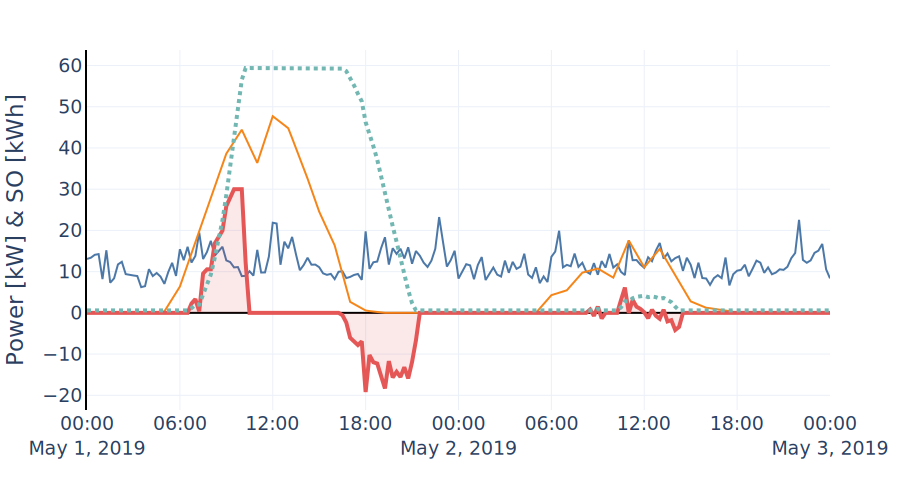

In [21]:
fig = px.line(graph.loc["2019-05-01 00:00:00":"2019-05-03 00:00:00", :],
              y=["community_kW", "pv_1kw", "storage", "soc"])
fig.data[2].update(fill="tozeroy", line_width=4,
                   fillcolor="rgba(214, 39, 40, 0.1)")
fig.data[3].update(line_width=4, line_dash="dot")
fig.update_layout(
    layout,
    height=500,
    width=900,
    showlegend=False,
    xaxis_title="",
    yaxis_title="Power [kW] & SO [kWh]",
    yaxis_showline=True, yaxis_linewidth=2, yaxis_linecolor='black',
    xaxis_showline=False, xaxis_linewidth=2, xaxis_linecolor='black',
    xaxis_tickangle=0)
fig.show()

In [21]:
fig.write_image("results/sample_valence_storage.svg")

In [22]:
pv_sizes = list(np.linspace(0.1, 5, 100))
self_prod = {}

for battery_size in [2, 4, 6, 8]:
    self_prod[battery_size] = []
    spec = {"min_kw": nb_houses * battery_size / 2,
            "max_kw": nb_houses * battery_size / 2,
            "max_kwh": nb_houses * battery_size,
            "eta": 0.95,
            "offset": 0.01}
    
    for pv_size in pv_sizes:
        graph = df.copy()
        graph.pv_1kw *= nb_houses * pv_size
        graph = individual_storage_control(graph, "community_kW", "pv_1kw", "storage", "soc", spec)
        
        res = def1_self_production(graph, cons_col="community_kW", prod_col="pv_1kw", storage="storage")
        self_prod[battery_size].append(res['self_prod'])

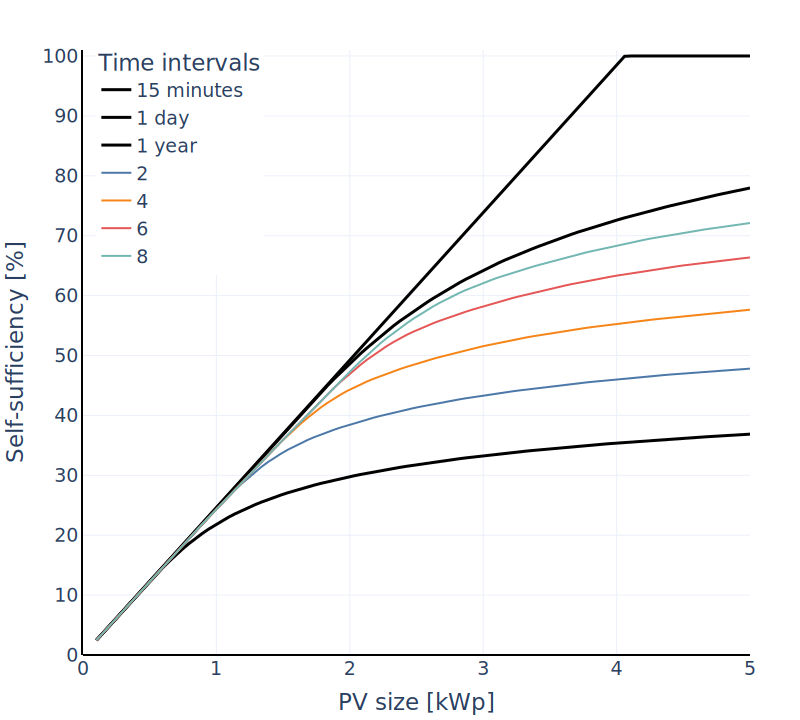

In [23]:
import plotly.graph_objects as go
fig = go.Figure(_fig)
fig.update_traces(line_color="black")

graph = pd.DataFrame(index=pv_sizes, data=self_prod)
for trace in px.line(graph).data:
    fig.add_trace(trace)
fig.show()

In [24]:
fig.write_image("results/battery_sensitivity.svg")

# Additionnal test for big batteries

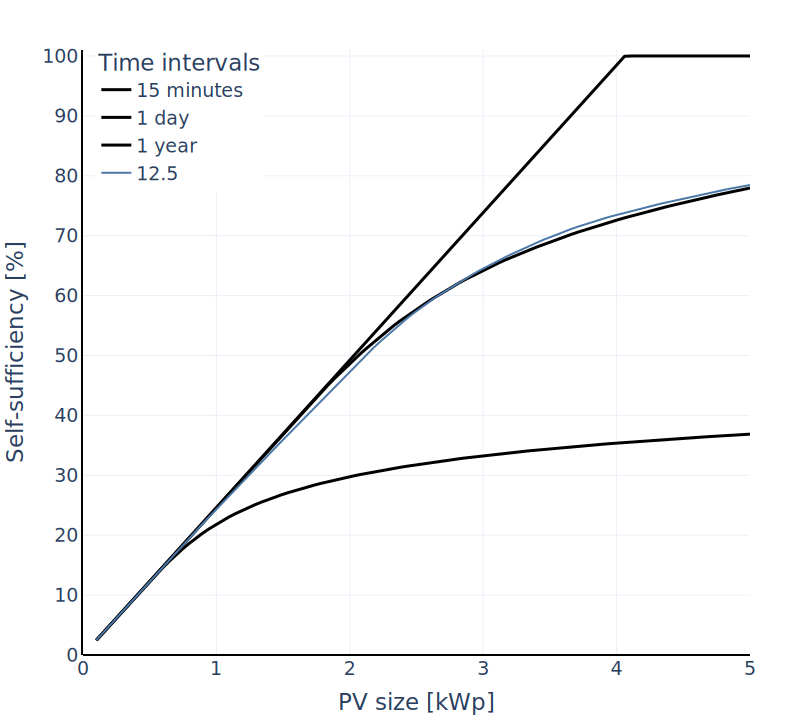

In [24]:
pv_sizes = list(np.linspace(0.1, 5, 100))
self_prod = {}

for battery_size in [12.5]:
    self_prod[battery_size] = []
    spec = {"min_kw": nb_houses * battery_size / 2,
            "max_kw": nb_houses * battery_size / 2,
            "max_kwh": nb_houses * battery_size,
            "eta": 0.95,
            "offset": 0.01}
    
    for pv_size in pv_sizes:
        graph = df.copy()
        graph.pv_1kw *= nb_houses * pv_size
        graph = individual_storage_control(graph, "community_kW", "pv_1kw", "storage", "soc", spec)
        
        res = def1_self_production(graph, cons_col="community_kW", prod_col="pv_1kw", storage="storage")
        self_prod[battery_size].append(res['self_prod'])

import plotly.graph_objects as go
fig = go.Figure(_fig)
fig.update_traces(line_color="black")

graph = pd.DataFrame(index=pv_sizes, data=self_prod)
for trace in px.line(graph).data:
    fig.add_trace(trace)
fig.show()